# BOLFI and failed simulations

Simulation runs can crash or return invalid output values for example due to numerical errors or because the simulation exceeds a time limit. This notebook demonstrates how a classifier-based approach could be used to improve robustness to failed simulations in BOLFI.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import elfi

In [3]:
seed = 120424
np.random.seed(seed)

## Example

Let's use a two-dimensional normal distribution with an unknown mean as an example.

In [4]:
from functools import partial
from elfi.examples.gauss import gauss_nd_mean, euclidean_multidim

In [5]:
dim = 2
bounds = {'mu_1': (0, 5), 'mu_2': (0, 5)}
true_1 = 3
true_2 = 3
n = 5
cov_matrix = (0.1 * np.diag(np.ones((dim,))) + 0.5 * np.ones((dim, dim)))

In [6]:
sim = partial(gauss_nd_mean, cov_matrix=cov_matrix, n_obs=n)
obs = sim(true_1, true_2)

The observed sample mean is close to the true mean.

In [7]:
%precision 2
np.mean(obs, axis=1)

array([[3.06, 3.05]])

We'll compare observed and simulated data based on the distance between sample means.

In [8]:
m = elfi.ElfiModel(name='gauss')
mu_1 = elfi.Prior('uniform', bounds['mu_1'][0], bounds['mu_1'][1]-bounds['mu_1'][0], model=m)
mu_2 = elfi.Prior('uniform', bounds['mu_2'][0], bounds['mu_2'][1]-bounds['mu_2'][0], model=m)
y = elfi.Simulator(sim, mu_1, mu_2, observed=obs)
mean = elfi.Summary(partial(np.mean, axis=1), y)
d = elfi.Discrepancy(euclidean_multidim, mean)

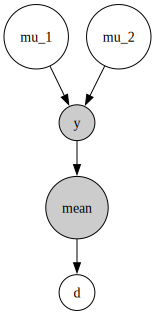

In [9]:
elfi.draw(d)

Here we run BOLFI with the same setup that is used in the [tutorial notebook](https://github.com/elfi-dev/notebooks/blob/master/BOLFI.ipynb).

In [10]:
bolfi = elfi.BOLFI(d, batch_size=1, initial_evidence=20, update_interval=10, bounds=bounds, acq_noise_var=0.1, seed=seed)
%time post = bolfi.fit(n_evidence=100)

Progress [==================================================] 100.0% Complete
CPU times: user 1min 4s, sys: 4.02 s, total: 1min 8s
Wall time: 2min 27s


Let's examine the acquired evidence and predicted discrepancies.

In [11]:
xlim = np.array([bounds[name] for name in m.parameter_names])
resolution = 101
xp_1 = np.linspace(xlim[0, 0], xlim[0, 1], resolution)
xp_2 = np.linspace(xlim[1, 0], xlim[1, 1], resolution)
X1, X2 = np.meshgrid(xp_1, xp_2)
xp = np.column_stack((X1.ravel(), X2.ravel()))

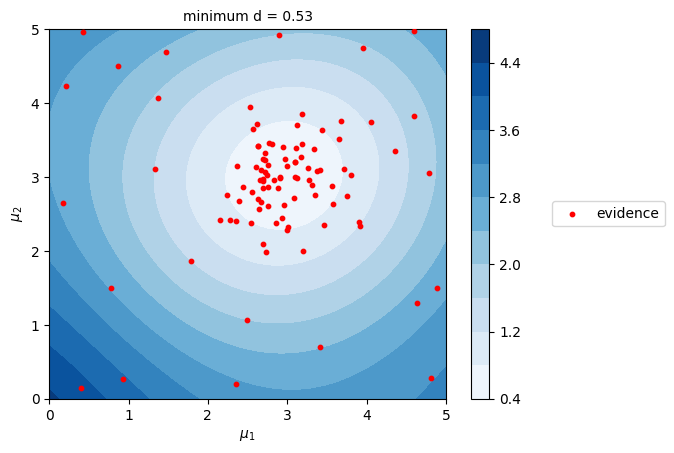

In [12]:
plot_model = bolfi.target_model
yp = plot_model.predict(xp)[0]
cset = plt.contourf(xp_1, xp_2, yp.reshape(resolution, resolution), levels=10, cmap='Blues')
plt.scatter(plot_model.X[:, 0], plot_model.X[:, 1], s=10, zorder=10, facecolors='r', label='evidence')
plt.xlim(xlim[0])
plt.ylim(xlim[1])
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.colorbar(cset)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5));
plt.title('minimum d = {:.2f}'.format(post.threshold), fontsize=10);

We can see that BOLFI has explored around the observed sample mean where the discrepancies between observed and simulated data are smallest. The predicted minimum `d` is used as a threshold when the fitted model is used to calculate approximate posterior probabilities.

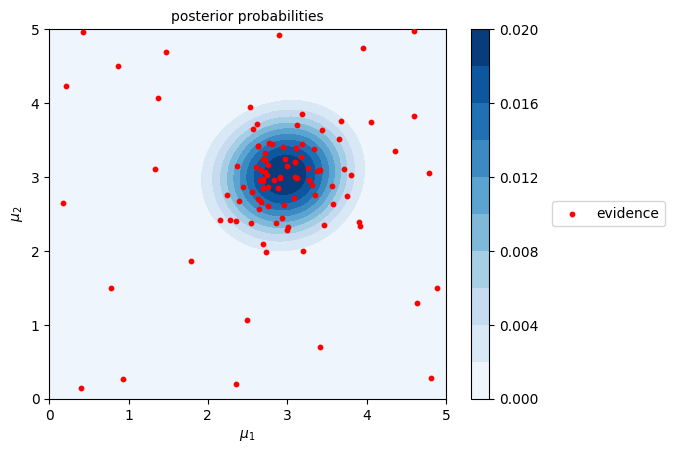

In [13]:
yp = post.pdf(xp)
cset = plt.contourf(xp_1, xp_2, yp.reshape(resolution, resolution), levels=10, cmap='Blues')
plt.scatter(plot_model.X[:, 0], plot_model.X[:, 1], s=10, zorder=10, facecolors='r', label='evidence')
plt.xlim(xlim[0])
plt.ylim(xlim[1])
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.colorbar(cset);
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5));
plt.title('posterior probabilities', fontsize=10);

## Random errors

Now assume that some simulation runs return an invalid output. Here we model the simulation failures as a random error.

In [14]:
def unreliable_sim(*params, batch_size=1, random_state=None):
    out = sim(*params, batch_size=batch_size, random_state=random_state)
    failed = np.random.rand(batch_size) < 0.1
    out[failed] = np.nan
    return out

In [15]:
y.become(elfi.Simulator(unreliable_sim, mu_1, mu_2, observed=obs))

We can observe the failed simulations when we run simulations with random parameter values and compute discrepancies between observed and simulated data.

In [16]:
d.generate(10)

array([1.04, 2.04, 1.65, 3.13, 3.68, 2.92, 1.33, 0.43, 1.95, 2.48])

BOLFI cannot handle the situation where all discrepancies do not have a finite value.

In [17]:
bolfi = elfi.BOLFI(d, batch_size=1, initial_evidence=20, update_interval=10, bounds=bounds, acq_noise_var=0.1, seed=seed)
%time post = bolfi.fit(n_evidence=100)

Progress [==================================================] 100.0% Complete
CPU times: user 2min 52s, sys: 7.23 s, total: 3min
Wall time: 4min 25s


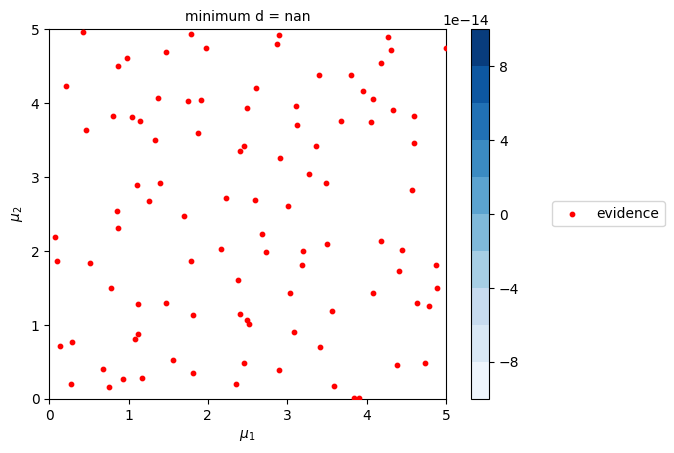

In [18]:
plot_model = bolfi.target_model
yp = plot_model.predict(xp)[0]
cset = plt.contourf(xp_1, xp_2, yp.reshape(resolution, resolution), levels=10, cmap='Blues')
plt.scatter(plot_model.X[:, 0], plot_model.X[:, 1], s=10, zorder=10, facecolors='r', label='evidence')
plt.xlim(xlim[0])
plt.ylim(xlim[1])
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.colorbar(cset)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5));
plt.title('minimum d = {:.2f}'.format(post.threshold), fontsize=10);

BOLFI has not been able to model the observed evidence, so the acquisitions are random and we do not have a model or a threshold for the approximate posterior calculations.

Let's now fit a failure-robust model version where non-finite output values are not used to update the discrepancy model.

In [19]:
target_model = elfi.RobustGPyRegression(m.parameter_names, bounds=bounds)
bolfi_1 = elfi.BOLFI(d, batch_size=1, initial_evidence=20, update_interval=10, bounds=bounds, acq_noise_var=0.1, seed=seed, target_model=target_model)

In [20]:
%time post = bolfi_1.fit(n_evidence=100)

Progress [==================================================] 100.0% Complete
CPU times: user 45.6 s, sys: 2.93 s, total: 48.5 s
Wall time: 1min 3s


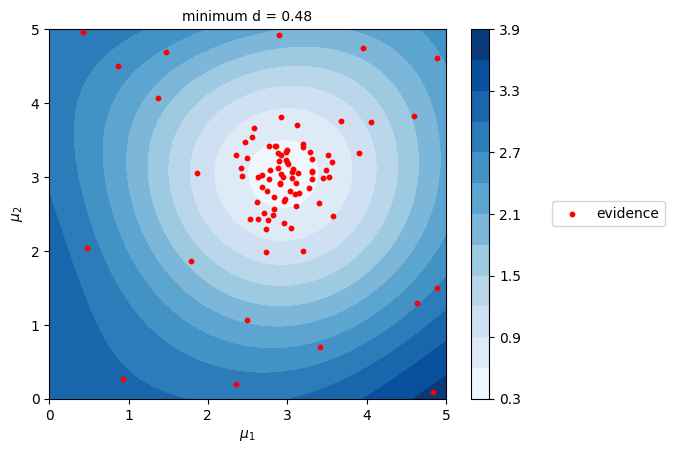

In [21]:
plot_model = bolfi_1.target_model
yp = plot_model.predict(xp)[0]
cset = plt.contourf(xp_1, xp_2, yp.reshape(resolution, resolution), levels=10, cmap='Blues')
plt.scatter(plot_model.X[:, 0], plot_model.X[:, 1], s=10, zorder=10, facecolors='r', label='evidence')
plt.xlim(xlim[0])
plt.ylim(xlim[1])
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.colorbar(cset)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5));
plt.title('minimum d = {:.2f}'.format(post.threshold), fontsize=10);

When the failed simulations are discarded, BOLFI is able to learn the dependencies between parameter values and discrepancies as usual. The main difference compared to a situation without failed simulations is that we need more than `n_evidence` iterations to observe `n_evidence` output values. The observed evidence count is stored in the model:

In [22]:
bolfi_1.target_model.n_evidence

91

While the failed simulations are not used to update the discrepancy model, all evidence points are also stored in the model so that we can check which input parameters resulted in the failed simulations.

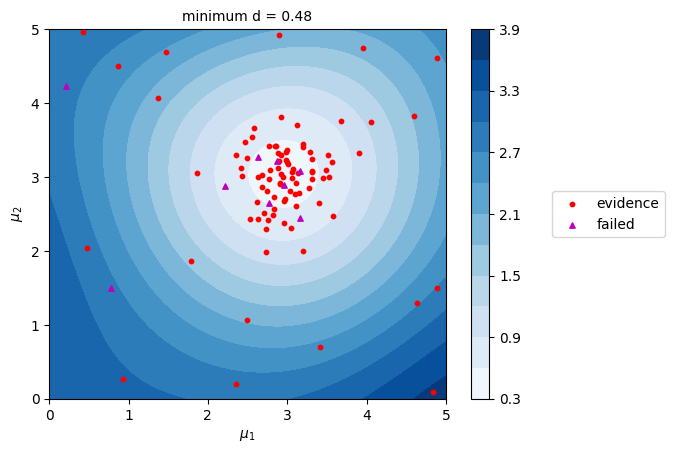

In [23]:
plot_model = bolfi_1.target_model
yp = plot_model.predict(xp)[0]
cset = plt.contourf(xp_1, xp_2, yp.reshape(resolution, resolution), levels=10, cmap='Blues')
plt.scatter(plot_model.X[:, 0], plot_model.X[:, 1], s=10, zorder=10, facecolors='r', label='evidence')
plt.xlim(xlim[0])
plt.ylim(xlim[1])
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.colorbar(cset);
plt.scatter(plot_model.failed[:, 0], plot_model.failed[:, 1], s=15, zorder=10, marker='^', facecolors='m', label='failed')
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5));
plt.title('minimum d = {:.2f}'.format(post.threshold), fontsize=10);

## Unknown constraints

We have now considered an example where the failed simulations arise at random without an obvious connection to the selected parameter values. However it is also possible that we observe simulation failures with certain parameter values.

In [24]:
def unknown_constraints_sim(*params, batch_size=1, random_state=None):
    out = sim(*params, batch_size=batch_size, random_state=random_state)
    failed = np.sqrt(np.sum(np.power(params, 2), axis=0)) < 2.5
    out[failed] = np.nan
    return out

In [25]:
y.become(elfi.Simulator(unknown_constraints_sim, mu_1, mu_2, observed=obs))
d.generate(10)

array([ nan, 1.99, 0.77,  nan, 1.36, 1.98,  nan, 0.36, 0.28,  nan])

Let's run BOLFI with the failure-robust model.

In [26]:
target_model = elfi.RobustGPyRegression(m.parameter_names, bounds=bounds)
bolfi_1 = elfi.BOLFI(d, batch_size=1, initial_evidence=20, update_interval=10, bounds=bounds, acq_noise_var=0.1, seed=seed, target_model=target_model)

In [27]:
%time post = bolfi_1.fit(n_evidence=100)

Progress [==================================================] 100.0% Complete
CPU times: user 38.8 s, sys: 1.33 s, total: 40.1 s
Wall time: 1min 5s


The observed evidence count is much lower than expected.

In [28]:
bolfi_1.target_model.n_evidence

18

This is because BOLFI has tried to learn about dependencies between parameter values and discrepancies where it is not possible due to persistent failures.

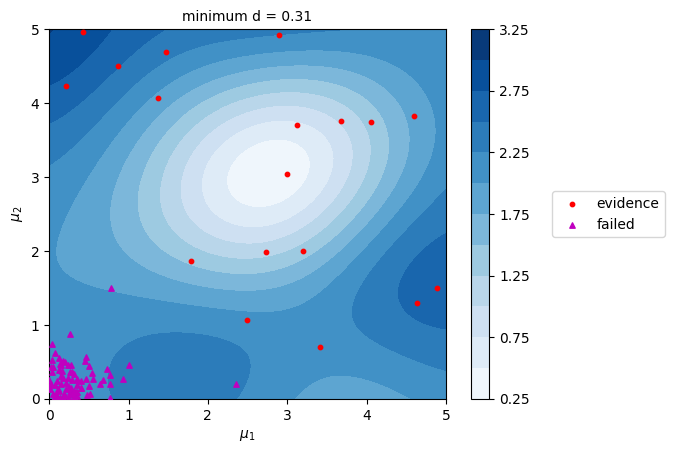

In [29]:
plot_model = bolfi_1.target_model
yp = plot_model.predict(xp)[0]
cset = plt.contourf(xp_1, xp_2, yp.reshape(resolution, resolution), levels=10, cmap='Blues')
plt.scatter(plot_model.X[:, 0], plot_model.X[:, 1], s=10, zorder=10, facecolors='r', label='evidence')
plt.xlim(xlim[0])
plt.ylim(xlim[1])
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.colorbar(cset);
plt.scatter(plot_model.failed[:, 0], plot_model.failed[:, 1], s=15, zorder=10, marker='^', facecolors='m', label='failed')
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5));
plt.title('minimum d = {:.2f}'.format(post.threshold), fontsize=10);

This example shows that when the simulation failures are not random, we cannot discard the failed simulations as uninformative. Instead we should use the failed simulations to learn about the unknown constraints that determine which parameter values produce valid simulation output. Here we will use a probabilistic classifier to model the unknown constraints and use the classifier predictions to either correct the predicted discrepancies as proposed in [1] or to scale acquisition values as proposed in [2]. 

We'll start with the approach where we substitute predicted discrepancies with an infinite value when the predicted failure probabilities exceed the threshold value `thd`.

In [30]:
target_model = elfi.RobustGPyRegression(m.parameter_names, bounds=bounds, train_classifier=True, thd=0.5)
bolfi_2 = elfi.BOLFI(d, batch_size=1, initial_evidence=20, update_interval=10, bounds=bounds, acq_noise_var=0.1, seed=seed, target_model=target_model)

In [31]:
%time post = bolfi_2.fit(n_evidence=100)

 /Users/umvremes/elfi_oma/elfi/methods/bo/acquisition.py:290: RuntimeWarning:divide by zero encountered in divide


Progress [==================================================] 100.0% Complete
CPU times: user 1min 2s, sys: 6.11 s, total: 1min 8s
Wall time: 1min 29s


The observed evidence count increases since BOLFI can now avoid parameter values that are expected to return a failed simulation and not provide information about the dependencies between parameter values and discrepancies.

In [32]:
bolfi_2.target_model.n_evidence

96

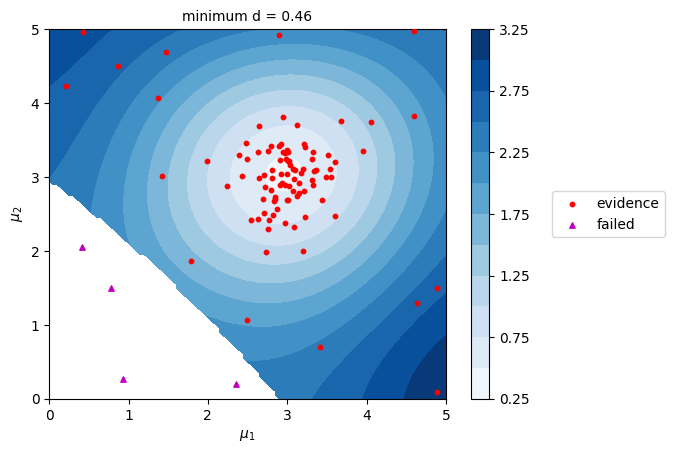

In [33]:
plot_model = bolfi_2.target_model
yp = plot_model.predict(xp)[0]
cset = plt.contourf(xp_1, xp_2, yp.reshape(resolution, resolution), levels=10, cmap='Blues')
plt.scatter(plot_model.X[:, 0], plot_model.X[:, 1], s=10, zorder=10, facecolors='r', label='evidence')
plt.xlim(xlim[0])
plt.ylim(xlim[1])
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.colorbar(cset);
plt.scatter(plot_model.failed[:, 0], plot_model.failed[:, 1], s=15, zorder=10, marker='^', facecolors='m', label='failed')
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5));
plt.title('minimum d = {:.2f}'.format(post.threshold), fontsize=10);

The difference between the last two optimisation runs is obvious when we plot the observed discrepancies (red dots) and failed simulations (vertical lines) with respect to the iteration.

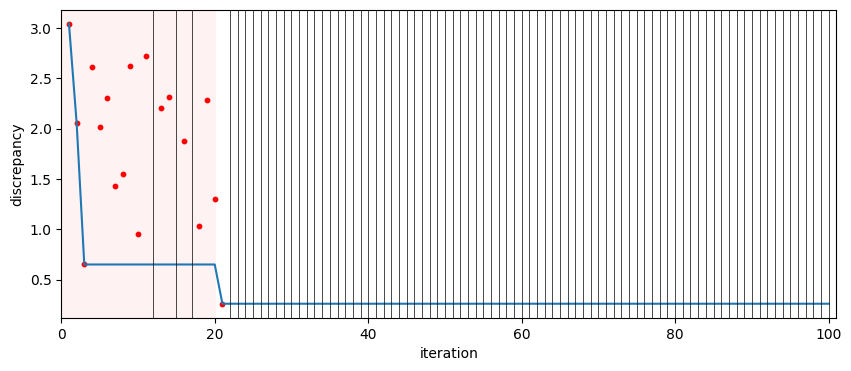

In [34]:
plot_model = bolfi_1.target_model  # BOLFI without classifier
plt.figure(figsize=(10, 4))
plt.plot(np.arange(plot_model.n_evidence_all)+1, np.minimum.accumulate(plot_model.Y_all))
plt.scatter(np.arange(plot_model.n_evidence_all)+1, plot_model.Y_all, s=10, color='r')
plt.axvspan(0, bolfi_1.n_initial_evidence + 0.15, facecolor='r', alpha=0.05)
plt.xlim(0, plot_model.n_evidence_all+1)
plt.xlabel('iteration')
plt.ylabel('discrepancy')
for n in range(plot_model.n_evidence_all):
    if not np.isfinite(plot_model.Y_all[n]):
        plt.axvline(n+1, color='k', linewidth=0.5)

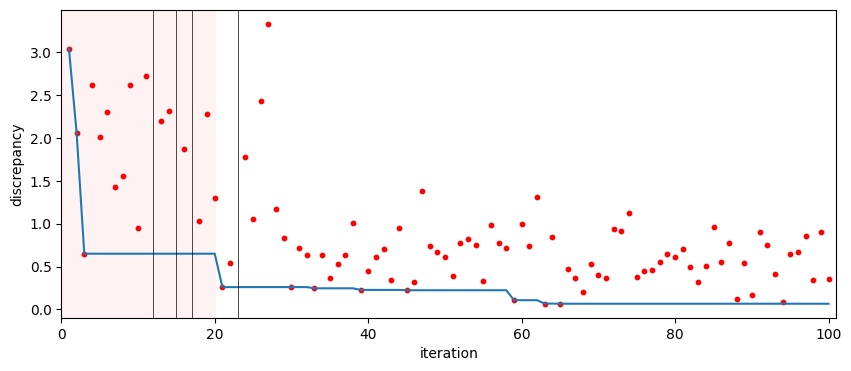

In [35]:
plot_model = bolfi_2.target_model  # BOLFI with classifier
plt.figure(figsize=(10, 4))
plt.plot(np.arange(plot_model.n_evidence_all)+1, np.minimum.accumulate(plot_model.Y_all))
plt.scatter(np.arange(plot_model.n_evidence_all)+1, plot_model.Y_all, s=10, color='r')
plt.axvspan(0, bolfi_2.n_initial_evidence + 0.15, facecolor='r', alpha=0.05)
plt.xlim(0, plot_model.n_evidence_all+1)
plt.xlabel('iteration')
plt.ylabel('discrepancy')
for n in range(plot_model.n_evidence_all):
    if not np.isfinite(plot_model.Y_all[n]):
        plt.axvline(n+1, color='k', linewidth=0.5)

When the classifier predictions are used to substitute predicted discrepancies with infinite values, the acquisition method will never choose parameter values that are not expected to produce valid simulation output. This approach has the problem that classification errors can lead us to exclude valid parameter values. While it is not possible to ensure that this does not happen, we can collect more initialisation data and use a lower threshold value `thd` to reduce the risk. 

Let's rerun with a lower threshold.

In [36]:
target_model = elfi.RobustGPyRegression(m.parameter_names, bounds=bounds, train_classifier=True, thd=0.1)
bolfi_2 = elfi.BOLFI(d, batch_size=1, initial_evidence=20, update_interval=10, bounds=bounds, acq_noise_var=0.1, seed=seed, target_model=target_model)

In [37]:
%time post = bolfi_2.fit(n_evidence=100)

Progress [==================================================] 100.0% Complete
CPU times: user 1min 5s, sys: 6.09 s, total: 1min 11s
Wall time: 1min 34s


The threshold parameter controls how much evidence is needed for parameter values to be excluded, so when the threshold is lower, BOLFI cannot exclude parameter values based on the initialisation data alone and we observe more failed simulations.

In [38]:
bolfi_2.target_model.n_evidence

83

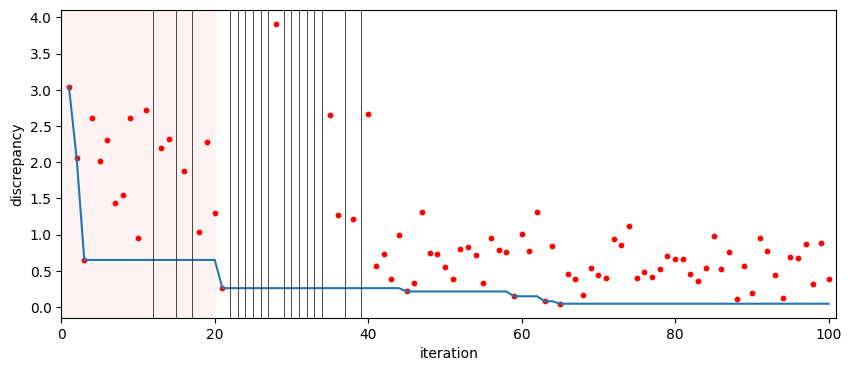

In [39]:
plot_model = bolfi_2.target_model
plt.figure(figsize=(10, 4))
plt.plot(np.arange(plot_model.n_evidence_all)+1, np.minimum.accumulate(plot_model.Y_all))
plt.scatter(np.arange(plot_model.n_evidence_all)+1, plot_model.Y_all, s=10, color='r')
plt.axvspan(0, bolfi_2.n_initial_evidence + 0.15, facecolor='r', alpha=0.05)
plt.xlim(0, plot_model.n_evidence_all+1)
plt.xlabel('iteration')
plt.ylabel('discrepancy')
for n in range(plot_model.n_evidence_all):
    if not np.isfinite(plot_model.Y_all[n]):
        plt.axvline(n+1, color='k', linewidth=0.5)

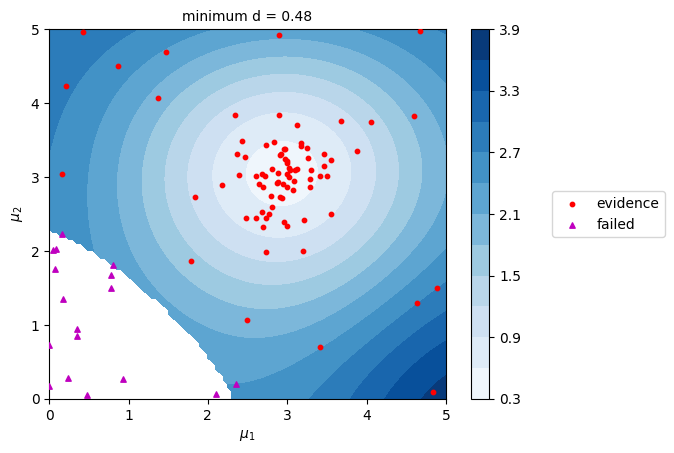

In [40]:
plot_model = bolfi_2.target_model
yp = plot_model.predict(xp)[0]
cset = plt.contourf(xp_1, xp_2, yp.reshape(resolution, resolution), levels=10, cmap='Blues')
plt.scatter(plot_model.X[:, 0], plot_model.X[:, 1], s=10, zorder=10, facecolors='r', label='evidence')
plt.xlim(xlim[0])
plt.ylim(xlim[1])
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.colorbar(cset);
plt.scatter(plot_model.failed[:, 0], plot_model.failed[:, 1], s=15, zorder=10, marker='^', facecolors='m', label='failed')
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5));
plt.title('minimum d = {:.2f}'.format(post.threshold), fontsize=10);

## Acquisition method

It's important to note that the effect from failed simulations depends on the acquisition method. The previous experiments used the default acquisition method that samples at the lower confidence bound.

Let's run BOLFI with an alternative acquisition method that samples at the maximum approximate posterior variance.

In [41]:
target_model = elfi.RobustGPyRegression(m.parameter_names, bounds=bounds)
prior = elfi.model.extensions.ModelPrior(m)
acq = elfi.methods.bo.acquisition.MaxVar(model=target_model, prior=prior, quantile_eps=0.05)
bolfi_3 = elfi.BOLFI(d, batch_size=1, initial_evidence=20, update_interval=10, bounds=bounds, seed=seed, target_model=target_model, acquisition_method=acq)

In [42]:
%time post = bolfi_3.fit(n_evidence=100)

Progress [==================================================] 100.0% Complete
CPU times: user 30.8 s, sys: 3.1 s, total: 33.9 s
Wall time: 27 s


While the failed simulations were now discarded and not used to learn about the simulator constraints, most simulations result in a valid output when the `MaxVar` acquisition method is used.

In [43]:
bolfi_3.target_model.n_evidence

76

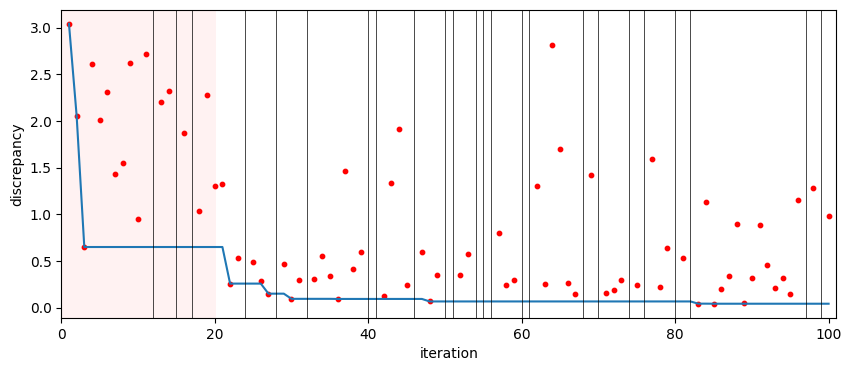

In [44]:
plot_model = bolfi_3.target_model
plt.figure(figsize=(10, 4))
plt.plot(np.arange(plot_model.n_evidence_all)+1, np.minimum.accumulate(plot_model.Y_all))
plt.scatter(np.arange(plot_model.n_evidence_all)+1, plot_model.Y_all, s=10, color='r')
plt.axvspan(0, bolfi_3.n_initial_evidence + 0.15, facecolor='r', alpha=0.05)
plt.xlim(0, plot_model.n_evidence_all+1)
plt.xlabel('iteration')
plt.ylabel('discrepancy')
for n in range(plot_model.n_evidence_all):
    if not np.isfinite(plot_model.Y_all[n]):
        plt.axvline(n+1, color='k', linewidth=0.5)

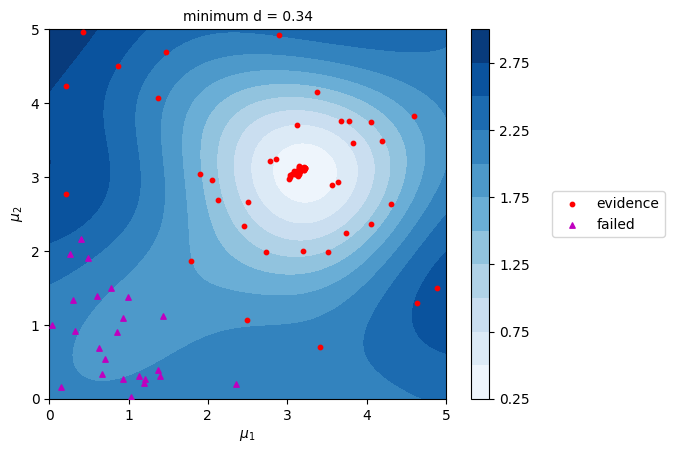

In [45]:
plot_model = bolfi_3.target_model
yp = plot_model.predict(xp)[0]
cset = plt.contourf(xp_1, xp_2, yp.reshape(resolution, resolution), levels=10, cmap='Blues')
plt.scatter(plot_model.X[:, 0], plot_model.X[:, 1], s=10, zorder=10, facecolors='r', label='evidence')
plt.xlim(xlim[0])
plt.ylim(xlim[1])
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.colorbar(cset);
plt.scatter(plot_model.failed[:, 0], plot_model.failed[:, 1], s=15, zorder=10, marker='^', facecolors='m', label='failed')
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5));
plt.title('minimum d = {:.2f}'.format(post.threshold), fontsize=10);

Note that since the discrepancy model cannot learn based on the failed simulations, model predictions remain uncertain in the area where simulations do not return valid output.

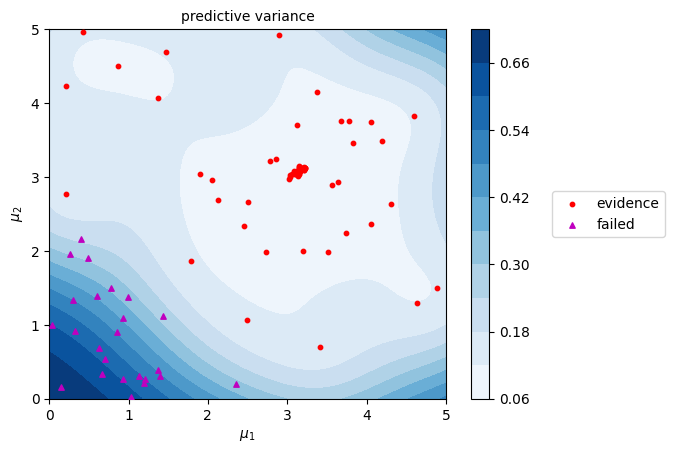

In [46]:
yp = plot_model.predict(xp)[1]
cset = plt.contourf(xp_1, xp_2, yp.reshape(resolution, resolution), levels=10, cmap='Blues')
plt.scatter(plot_model.X[:, 0], plot_model.X[:, 1], s=10, zorder=10, facecolors='r', label='evidence')
plt.xlim(xlim[0])
plt.ylim(xlim[1])
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.colorbar(cset);
plt.scatter(plot_model.failed[:, 0], plot_model.failed[:, 1], s=15, zorder=10, marker='^', facecolors='m', label='failed')
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5));
plt.title('predictive variance', fontsize=10);

While this acquisition method handles failed simulations better than the default method, the resources spent on the failed simulation runs could be considered wasted. Let's rerun optimisation with the classifier-extended model for comparison.

In [47]:
target_model = elfi.RobustGPyRegression(m.parameter_names, bounds=bounds, train_classifier=True, thd=0.5)
prior = elfi.model.extensions.ModelPrior(m)
acq = elfi.methods.bo.acquisition.MaxVar(model=target_model, prior=prior, quantile_eps=0.05)
bolfi_4 = elfi.BOLFI(d, batch_size=1, initial_evidence=20, update_interval=10, bounds=bounds, seed=seed, target_model=target_model, acquisition_method=acq)

In [48]:
%time post = bolfi_4.fit(n_evidence=100)

Progress [==================================================] 100.0% Complete
CPU times: user 44.7 s, sys: 5.95 s, total: 50.6 s
Wall time: 35.7 s


In [49]:
bolfi_4.target_model.n_evidence

95

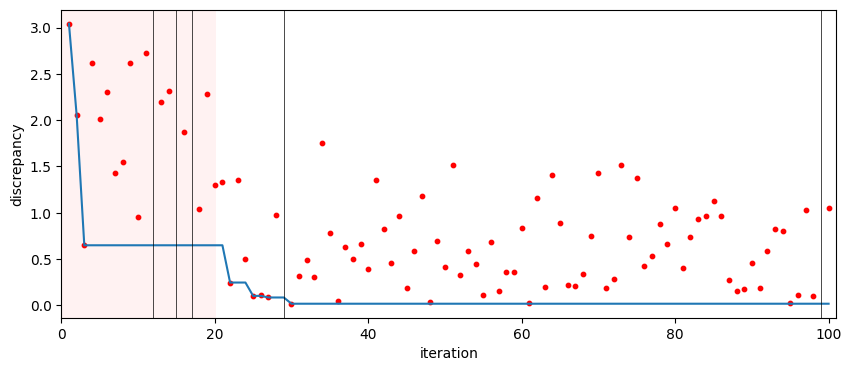

In [50]:
plot_model = bolfi_4.target_model
plt.figure(figsize=(10, 4))
plt.plot(np.arange(plot_model.n_evidence_all)+1, np.minimum.accumulate(plot_model.Y_all))
plt.scatter(np.arange(plot_model.n_evidence_all)+1, plot_model.Y_all, s=10, color='r')
plt.axvspan(0, bolfi_4.n_initial_evidence + 0.15, facecolor='r', alpha=0.05)
plt.xlim(0, plot_model.n_evidence_all+1)
plt.xlabel('iteration')
plt.ylabel('discrepancy')
for n in range(plot_model.n_evidence_all):
    if not np.isfinite(plot_model.Y_all[n]):
        plt.axvline(n+1, color='k', linewidth=0.5)

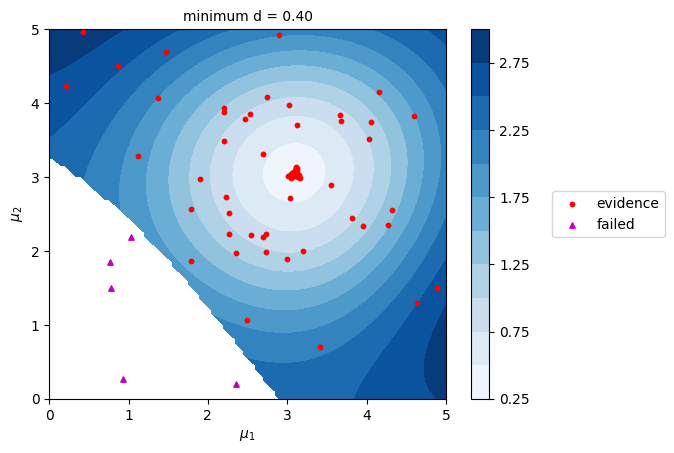

In [51]:
plot_model = bolfi_4.target_model
yp = plot_model.predict(xp)[0]
cset = plt.contourf(xp_1, xp_2, yp.reshape(resolution, resolution), levels=10, cmap='Blues')
plt.scatter(plot_model.X[:, 0], plot_model.X[:, 1], s=10, zorder=10, facecolors='r', label='evidence')
plt.xlim(xlim[0])
plt.ylim(xlim[1])
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.colorbar(cset);
plt.scatter(plot_model.failed[:, 0], plot_model.failed[:, 1], s=15, zorder=10, marker='^', facecolors='m', label='failed')
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5));
plt.title('minimum d = {:.2f}'.format(post.threshold), fontsize=10);

## Multiplicative adjustment

The classifier predictions can also be used to scale acquisition scores rather than set hard constraints [2].

In [52]:
from elfi.methods.bo.utils import AdjustmentFunction, make_multiplicative_acq

In [53]:
target_model = elfi.RobustGPyRegression(m.parameter_names, bounds=bounds, train_classifier=True, thd=0)
prob_success = AdjustmentFunction(target_model.success_proba, target_model.success_proba_gradients)
acq = make_multiplicative_acq(elfi.methods.bo.acquisition.MaxVar, prob_success)(model=target_model, prior=prior, quantile_eps=0.05)
bolfi_5 = elfi.BOLFI(d, batch_size=1, initial_evidence=20, update_interval=10, bounds=bounds, seed=seed, target_model=target_model, acquisition_method=acq)

In [54]:
%time post = bolfi_5.fit(n_evidence=100)

Progress [==================================================] 100.0% Complete
CPU times: user 1min 26s, sys: 6.53 s, total: 1min 32s
Wall time: 1min 17s


Here the acquisition method has a chance to explore also parameter values that produce failed simulations, but the multiplicative adjustment should ensure that it prioritises parameter values that are expected to produce valid simulation output.

In [55]:
bolfi_5.target_model.n_evidence

93

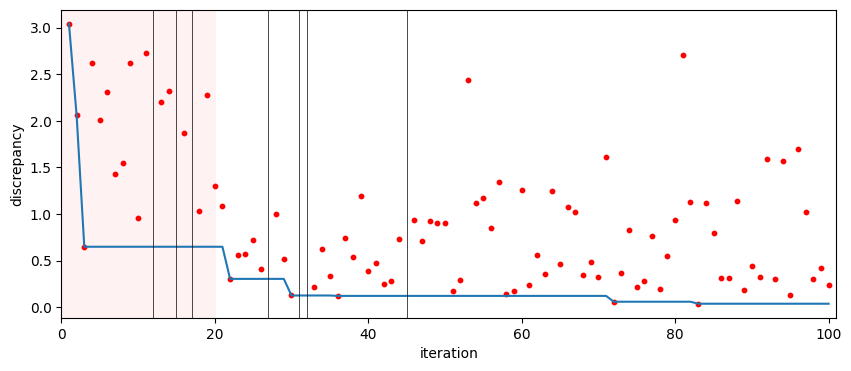

In [56]:
plot_model = bolfi_5.target_model
plt.figure(figsize=(10, 4))
plt.plot(np.arange(plot_model.n_evidence_all)+1, np.minimum.accumulate(plot_model.Y_all))
plt.scatter(np.arange(plot_model.n_evidence_all)+1, plot_model.Y_all, s=10, color='r')
plt.axvspan(0, bolfi_5.n_initial_evidence + 0.15, facecolor='r', alpha=0.05)
plt.xlim(0, plot_model.n_evidence_all+1)
plt.xlabel('iteration')
plt.ylabel('discrepancy')
for n in range(plot_model.n_evidence_all):
    if not np.isfinite(plot_model.Y_all[n]):
        plt.axvline(n+1, color='k', linewidth=0.5)

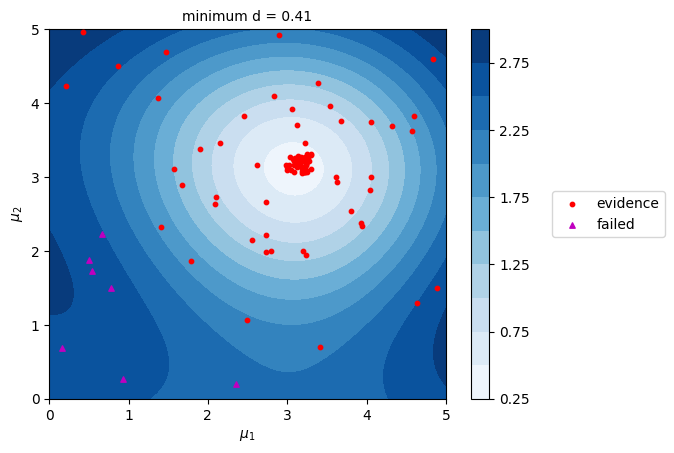

In [57]:
plot_model = bolfi_5.target_model
yp = plot_model.predict(xp)[0]
cset = plt.contourf(xp_1, xp_2, yp.reshape(resolution, resolution), levels=10, cmap='Blues')
plt.scatter(plot_model.X[:, 0], plot_model.X[:, 1], s=10, zorder=10, facecolors='r', label='evidence')
plt.xlim(xlim[0])
plt.ylim(xlim[1])
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.colorbar(cset);
plt.scatter(plot_model.failed[:, 0], plot_model.failed[:, 1], s=15, zorder=10, marker='^', facecolors='m', label='failed')
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5));
plt.title('minimum d = {:.2f}'.format(post.threshold), fontsize=10);

Multiplicative adjustment works with acquisition functions like `MaxVar` and `ExpIntVar` that have the minimum value zero.

## References

[1]  El Gammal J, Schöneberg N, Torrado J, Fidler C. Fast and robust Bayesian inference using Gaussian processes with GPry. JCAP 10: 021, 2023. https://doi.org/10.1088/1475-7516/2023/10/021

[2] Chakrabarty A, Bortoff SA, Laughman CR. Simulation Failure Robust Bayesian Optimization for Estimating Black-Box Model Parameters. In Proc. SMC 2021. https://doi.org/10.1109/SMC52423.2021.9658893